# Phase 1: Environment Setup
Importing essential libraries for data manipulation, visualization, and machine learning.
**Key Libraries:**
* `Pandas/Numpy`: For data structure handling.
* `Seaborn/Matplotlib`: For exploratory data analysis (EDA).
* `Sklearn`: For splitting data and metrics. We will import specific model libraries later.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn utilities
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler 

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Set plot style
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


# Phase 2: Data Loading & Initial Inspection
Loading the Credit Card Fraud dataset. We check the shape, data types, and look for missing values.

In [2]:
# Load data
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# Quick inspection
print(f"Dataset Shape: {df.shape}")
print("-" * 30)
print("Missing Values per column:")
print(df.isnull().sum().max()) # Should be 0 for this clean dataset
print("-" * 30)
print("Class Distribution:")
print(df['Class'].value_counts())
print(f"Fraud Percentage: {df['Class'].mean()*100:.3f}%")

# Preview
df.head()

Dataset Shape: (284807, 31)
------------------------------
Missing Values per column:
0
------------------------------
Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Fraud Percentage: 0.173%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Phase 3: Feature Engineering
Creating new features before splitting to capture better patterns.
1. **Hour:** Converted from 'Time' (seconds) to capture daily cycles.
2. **Amount_log:** Logarithmic transformation of 'Amount' to reduce skewness (financial data often has a 'long tail').

In [3]:
# 1. Convert Time (seconds) to Hours
df['Hour'] = (df['Time'] / 3600) % 24

# 2. Log transform Amount (we add +1 to avoid log(0) error)
# This compresses the massive range of transaction amounts
df['Amount_log'] = np.log1p(df['Amount'])

# 3. Drop original columns (Time is replaced by Hour)
# We keep 'Amount' purely for comparison or RobustScaling later if we choose,
# but usually 'Amount_log' is sufficient. Let's drop the original 'Time' now.
df = df.drop(['Time'], axis=1)

print("New features created. Original 'Time' column dropped.")
df.head()

New features created. Original 'Time' column dropped.


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,Amount_log
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000,5.014760
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000,1.305626
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000278,5.939276
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000278,4.824306
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000556,4.262539


# Phase 4: Train-Test Split
**Crucial Step:** We split the data *before* scaling to prevent Data Leakage.
We use `stratify=y` to ensure the test set has the same proportion of Fraud (0.17%) as the training set.

In [4]:
# Define Features (X) and Target (y)
# We drop 'Class' from X. We also drop 'Amount' since we have 'Amount_log'.
X = df.drop(['Class', 'Amount'], axis=1)
y = df['Class']

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Fraud cases in Train: {y_train.sum()}")
print(f"Fraud cases in Test: {y_test.sum()}")

X_train shape: (227845, 30)
X_test shape: (56962, 30)
Fraud cases in Train: 394
Fraud cases in Test: 98


# Phase 5: Scaling
We use `RobustScaler` on the `Amount_log` and `Hour` columns.
**Rule:** Fit on Train, Transform on Test.
Note: Columns V1-V28 are already PCA scaled, so we only need to scale our new features.

In [5]:
# Initialize scaler
scaler = RobustScaler()

# Columns to scale (V1-V28 are already scaled)
cols_to_scale = ['Amount_log', 'Hour']

# FIT on training data only
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# TRANSFORM test data (using stats from train)
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Scaling complete. First 5 rows of X_train:")
X_train.head()

Scaling complete. First 5 rows of X_train:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Hour,Amount_log
265518,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,-0.157403,...,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,0.683631,-0.411696
180305,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,0.284864,...,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,-0.508068,-0.709232
42664,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,-2.009561,...,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,-0.408956,0.824159
198723,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,1.756121,...,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,-0.248767,-0.475897
82325,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,-0.558955,...,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,0.169292,0.539125


# Phase 6: Baseline Modeling
## 6.1 The "Dummy" Classifier
We start with a naive predictor that always predicts 'Legit' (Class 0).
This establishes our "floor." Any useful model must beat this, specifically on **Recall** (catching fraud).

In [6]:
from sklearn.dummy import DummyClassifier

# 1. Create a dummy classifier that always predicts the majority class (0: Legit)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

# 2. Generate predictions
y_pred_dummy = dummy.predict(X_test)

# 3. Check the "Accuracy" (It will be high, but misleading!)
print("Dummy Classifier Accuracy:", dummy.score(X_test, y_test))

# 4. Check the Confusion Matrix
# Format:
# [[TN, FP],
#  [FN, TP]]
print("\nConfusion Matrix (Dummy):")
print(confusion_matrix(y_test, y_pred_dummy))

Dummy Classifier Accuracy: 0.9982795547909132

Confusion Matrix (Dummy):
[[56864     0]
 [   98     0]]


## 6.2 Logistic Regression (Simple Baseline)
We use Logistic Regression as our first real model. It's simple, interpretable, and efficient.
* **Solver:** `liblinear` is often good for smaller datasets or binary classification.

In [7]:
from sklearn.linear_model import LogisticRegression

# 1. Initialize Model
# We use default parameters for now to get a raw baseline
log_reg = LogisticRegression(solver='liblinear', random_state=42)

# 2. Train
log_reg.fit(X_train, y_train)

# 3. Predict
y_pred_log = log_reg.predict(X_test)

print("Logistic Regression trained.")

Logistic Regression trained.


## 6.3 Evaluation
We stop looking at Accuracy. We look at:
* **Confusion Matrix:** The raw counts of what we got right/wrong.
* **Recall (Sensitivity):** Out of all ACTUAL frauds, how many did we catch?
* **Precision:** Out of all FLAGGED frauds, how many were actually fraud?

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_scores(y_true, y_pred, model_name):
    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}  <-- MOST IMPORTANT")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    # Using a DataFrame for clearer labeling
    cm_df = pd.DataFrame(cm, columns=['Pred: Legit', 'Pred: Fraud'], index=['Actual: Legit', 'Actual: Fraud'])
    print(cm_df)
    print("-" * 30)

# Evaluate both
print_scores(y_test, y_pred_dummy, "Dummy Classifier")
print_scores(y_test, y_pred_log, "Logistic Regression")

--- Dummy Classifier Evaluation ---
Accuracy:  0.9983
Precision: 0.0000
Recall:    0.0000  <-- MOST IMPORTANT
F1 Score:  0.0000

Confusion Matrix:
               Pred: Legit  Pred: Fraud
Actual: Legit        56864            0
Actual: Fraud           98            0
------------------------------
--- Logistic Regression Evaluation ---
Accuracy:  0.9992
Precision: 0.8312
Recall:    0.6531  <-- MOST IMPORTANT
F1 Score:  0.7314

Confusion Matrix:
               Pred: Legit  Pred: Fraud
Actual: Legit        56851           13
Actual: Fraud           34           64
------------------------------


# Phase 7: Handling Class Imbalance
## 7.1 Weighted Logistic Regression
Standard Logistic Regression treats all errors equally.
By using `class_weight='balanced'`, we penalize the model heavily for missing the minority class (Fraud).
This usually increases **Recall** (catching more fraud) at the expense of **Precision** (more false alarms).

In [9]:
# 1. Initialize Weighted Model
# 'balanced' automatically adjusts weights inversely proportional to class frequencies
log_reg_balanced = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

# 2. Train
log_reg_balanced.fit(X_train, y_train)

# 3. Predict
y_pred_balanced = log_reg_balanced.predict(X_test)

# 4. Evaluate
print_scores(y_test, y_pred_log, "Original Logistic Regression")
print_scores(y_test, y_pred_balanced, "Weighted Logistic Regression")

--- Original Logistic Regression Evaluation ---
Accuracy:  0.9992
Precision: 0.8312
Recall:    0.6531  <-- MOST IMPORTANT
F1 Score:  0.7314

Confusion Matrix:
               Pred: Legit  Pred: Fraud
Actual: Legit        56851           13
Actual: Fraud           34           64
------------------------------
--- Weighted Logistic Regression Evaluation ---
Accuracy:  0.9730
Precision: 0.0551
Recall:    0.9082  <-- MOST IMPORTANT
F1 Score:  0.1039

Confusion Matrix:
               Pred: Legit  Pred: Fraud
Actual: Legit        55337         1527
Actual: Fraud            9           89
------------------------------


# Phase 8: Threshold Tuning
## 8.1 Precision-Recall Curve
Since we cannot accept a model with 5% precision, we analyze the **Precision-Recall Curve**.
We want to find a threshold that gives us high Recall (catching fraud) without overwhelming the review team (acceptable Precision).

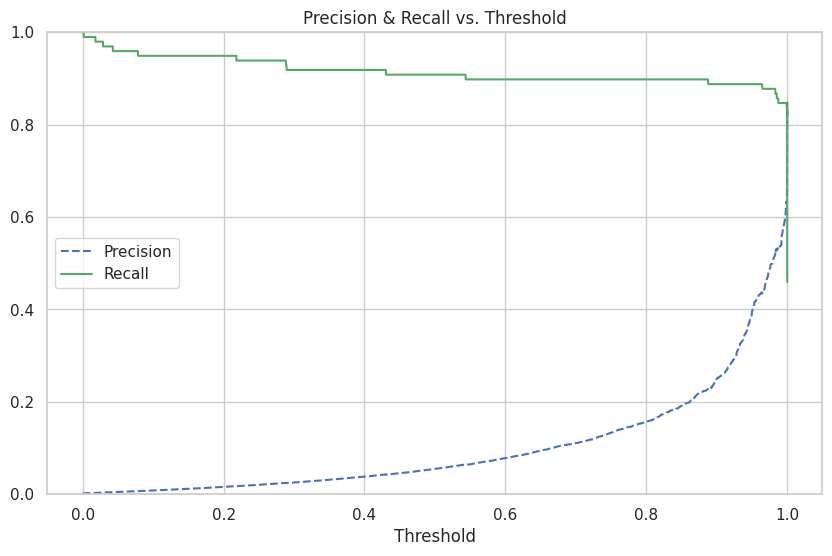

In [10]:
from sklearn.metrics import precision_recall_curve

# 1. Get probabilities instead of Class labels (0 or 1)
# predict_proba returns [Prob_Legit, Prob_Fraud]. We want column 1.
y_scores = log_reg_balanced.predict_proba(X_test)[:, 1]

# 2. Calculate curves
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# 3. Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="center left")
plt.title("Precision & Recall vs. Threshold")
plt.ylim([0, 1])
plt.grid(True)
plt.show()

## 8.2 Finding the Optimal F1 Threshold
Since the intersection happens at the extreme right, we calculate the F1 score for every possible threshold and pick the one that gives the highest combined score.

In [11]:
# 1. Calculate F1 score for each threshold
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
# Note: we add a tiny epsilon (1e-6) to avoid division by zero
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

# 2. Find the index of the highest F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score:  {f1_scores[best_idx]:.4f}")
print(f"Precision at Best: {precisions[best_idx]:.4f}")
print(f"Recall at Best:    {recalls[best_idx]:.4f}")

Best Threshold: 1.0000
Best F1 Score:  0.8247
Precision at Best: 0.8333
Recall at Best:    0.8163


## 8.3 Final Evaluation (Optimal Threshold)
We apply the optimal threshold to generate hard predictions (0 or 1).
This represents the best possible performance of our Linear Baseline.

In [12]:
from sklearn.metrics import classification_report

# 1. Apply the threshold to get final predictions
# We use >= because the threshold might be exactly equal to the highest score
y_pred_optimal = (y_scores >= best_threshold).astype(int)

# 2. Print the Final Report
print("--- Final Logistic Regression (Optimized) ---")
print(classification_report(y_test, y_pred_optimal))

# 3. Final Confusion Matrix
print("\nFinal Confusion Matrix:")
cm_final = confusion_matrix(y_test, y_pred_optimal)
cm_final_df = pd.DataFrame(cm_final, columns=['Pred: Legit', 'Pred: Fraud'], index=['Actual: Legit', 'Actual: Fraud'])
print(cm_final_df)

--- Final Logistic Regression (Optimized) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962


Final Confusion Matrix:
               Pred: Legit  Pred: Fraud
Actual: Legit        56848           16
Actual: Fraud           18           80


## 8.4 Model Comparision Plot

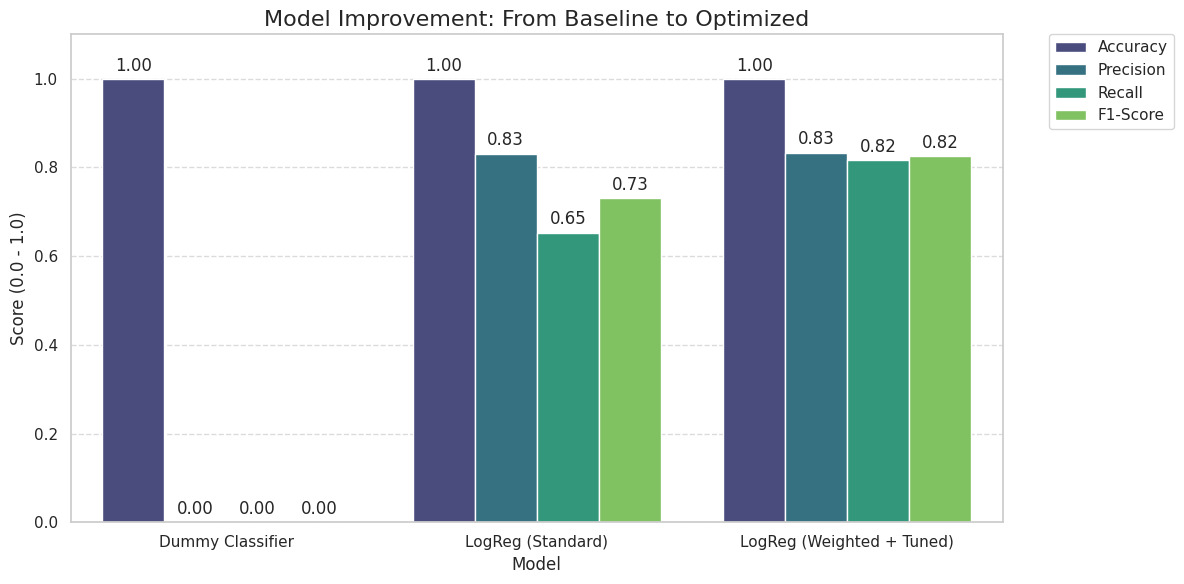

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Manually create a DataFrame with your results
# (I took these numbers from your previous outputs)
results_data = {
    'Model': ['Dummy Classifier', 'LogReg (Standard)', 'LogReg (Weighted + Tuned)'],
    'Accuracy': [0.9983, 0.9992, 1.0000],
    'Precision': [0.0000, 0.8312, 0.8333],
    'Recall':    [0.0000, 0.6531, 0.8163], # The metric we care about most
    'F1-Score':  [0.0000, 0.7314, 0.8247]
}

df_results = pd.DataFrame(results_data)

# 2. Melt the DataFrame to make it easy to plot with Seaborn
# This transforms the data from "wide" to "long" format
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

# 3. Create the Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric", palette="viridis")

# 4. Add formatting
plt.title("Model Improvement: From Baseline to Optimized", fontsize=16)
plt.ylim(0, 1.1)
plt.ylabel("Score (0.0 - 1.0)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Move legend outside
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 5. Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()